# Decision Uncertainty A/B Test — Analysis

 **Project:** Does Showing Uncertainty Change Decisions?

 This notebook analyzes results from a simulated A/B experiment testing whether
 explicitly showing uncertainty (evidence strength / confidence) affects decision behavior.

 We test:
    1. Whether showing uncertainty increases sensitivity to evidence quality
    2. Whether it improves decision quality under weak evidence
    3. Whether it increases decision time (tradeoff)

 The data were generated via a reproducible simulation (`simulate_data.py`).

In [3]:
# 1. Setup & Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf


pd.set_option("display.max_columns", None)

In [12]:
# 2. Load data

df = pd.read_csv("../data/raw/decisions_analysis_ready.csv")
print(df.shape)
df.head()

(500, 12)


,decision_id,decision_maker_id,scenario_id,treatment_group,estimated_effect,standard_error,ci_width,evidence_strength,true_effect,chosen_option,decision_time_sec,correct_direction
0,1,1.0,13,1,-5.758402,1.178657,4.620335,Low,-5.531675,0,24.965288,1
1,2,1.0,16,1,5.554397,1.049736,4.114965,Moderate,6.781200,1,20.850207,1
2,3,1.0,11,1,-1.780356,0.778117,3.050218,High,-2.395871,0,23.402794,1
3,4,1.0,18,1,4.030810,0.703965,2.759543,High,5.017664,1,22.076895,1
4,5,1.0,6,1,3.768899,0.895981,3.512246,Moderate,4.656401,1,22.099651,1


Each row represents one decision made by one decision-maker in one scenario, under either the control (point estimate only) or treatment (uncertainty shown) condition.

In [13]:
# 3. Basic Experiment Checks

# Treatment split
(df["treatment_group"].value_counts(normalize=True)
.rename({0: "Control", 1: "Treatment"}))


# %%
# Unique decision-makers per group
df.groupby("treatment_group")["decision_maker_id"].nunique()


# %%
# Evidence strength distribution by group
pd.crosstab(df["evidence_strength"], df["treatment_group"], normalize="columns")

treatment_group,0,1
evidence_strength,,
High,0.347826,0.327935
Low,0.320158,0.319838
Moderate,0.332016,0.352227


**Treatment group** (evidence strength/uncertainty shown) = **1**  
**Control group** (just point estimate shown) = **0**

I expect treatment assignment to be approximately balanced and independent of evidence strength. Small deviations are acceptable due to randomness. The above table aligns with this expectation.

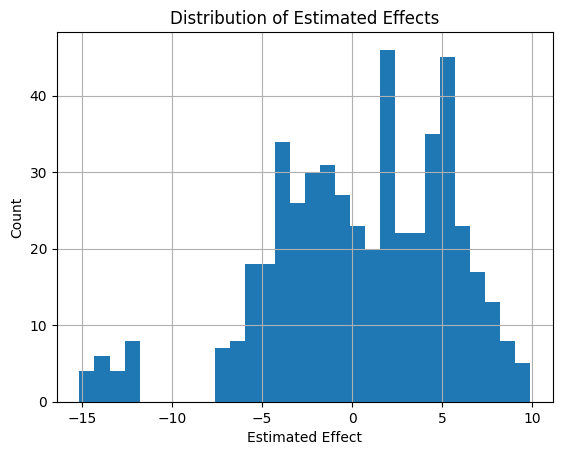

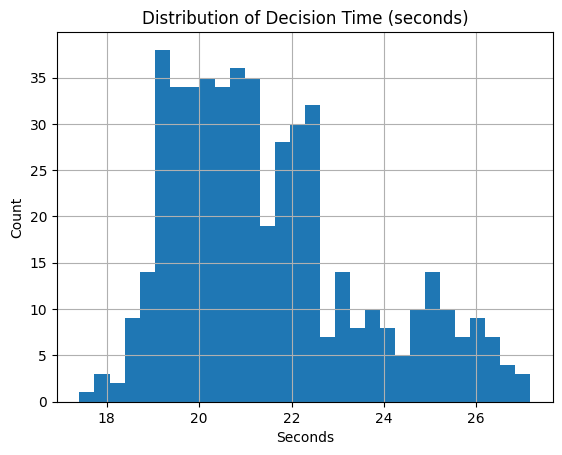

treatment_group,0,1
chosen_option,,
0,0.442688,0.473684
1,0.557312,0.526316


In [14]:
# 4. Exploratory Distributions

# Estimated effects
plt.figure()
df["estimated_effect"].hist(bins=30)
plt.title("Distribution of Estimated Effects")
plt.xlabel("Estimated Effect")
plt.ylabel("Count")
plt.show()


# %%
# Decision times
plt.figure()
df["decision_time_sec"].hist(bins=30)
plt.title("Distribution of Decision Time (seconds)")
plt.xlabel("Seconds")
plt.ylabel("Count")
plt.show()


# %%
# Choice rate by treatment group
pd.crosstab(df["chosen_option"], df["treatment_group"], normalize="columns")

`chosen_option = 1` indicates selecting the option with the estimated positive effect.

In [15]:
# 5. Primary Hypothesis
# Does uncertainty increase sensitivity to evidence quality?

# Logistic regression with interaction
model_primary = smf.logit(
"chosen_option ~ treatment_group * evidence_strength",
data=df
).fit()


print(model_primary.summary())

Optimization terminated successfully.
         Current function value: 0.677832
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:          chosen_option   No. Observations:                  500
Model:                          Logit   Df Residuals:                      494
Method:                           MLE   Df Model:                            5
Date:                Mon, 02 Feb 2026   Pseudo R-squ.:                 0.01709
Time:                        08:46:42   Log-Likelihood:                -338.92
converged:                       True   LL-Null:                       -344.81
Covariance Type:            nonrobust   LLR p-value:                   0.03789
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                             

The logistic regression did not detect statistically significant main effects of evidence strength, treatment assignment, or their interaction on the probability of choosing the option with a positive estimated effect.

Specifically:
- Evidence strength was not associated with choice behavior in the control condition.
- Showing uncertainty did not independently increase or decrease selection rates.
- Interaction terms between treatment and evidence strength were small and imprecise, providing no evidence that uncertainty display meaningfully altered sensitivity to evidence quality in this simulated setting.

Although the likelihood ratio test for the full model is statistically significant (LLR p = 0.038), individual coefficients are not. This pattern suggests that any predictive signal in the model is weak and distributed across parameters rather than driven by a clear, interpretable effect. The pseudo R² (0.017) further indicates that treatment assignment and evidence strength explain little of the overall variation in individual choices.

From a decision-making perspective, these results suggest that simply presenting uncertainty is not sufficient to reliably change binary choice behavior. If uncertainty affects decision-making, it may operate through more subtle channels (e.g., deliberation time, consistency, or downstream outcomes) rather than immediate choice reversal.


In [16]:
# Predicted probabilities by group and evidence strength
pred_df = df.copy()
pred_df["pred_prob"] = model_primary.predict(pred_df)


(pred_df.groupby(["treatment_group", "evidence_strength"])["pred_prob"]
.mean()
.unstack())

evidence_strength,High,Low,Moderate
treatment_group,,,
0,0.579545,0.481481,0.607143
1,0.592593,0.392405,0.586207


Predicted probabilities show modest differences in choice behavior across evidence strength levels and treatment conditions, but no clear monotonic pattern.

In the control group, the probability of selecting the option with a positive estimated effect is lowest under low evidence (0.48) and higher under moderate (0.61) and high evidence (0.58), suggesting some baseline sensitivity to evidence quality.

In the treatment group, predicted probabilities are similar under high (0.59) and moderate (0.59) evidence, but notably lower under low evidence (0.39). This pattern isconsistent with increased caution when uncertainty is explicitly displayed, particularly in low-evidence scenarios.

**Comparing groups, the largest divergence occurs under low evidence, where the treatment group is approximately 9 percentage points less likely to choose the positive-effect option than the control group. Differences under moderate and high evidence are small (≤3 percentage points).**

Although these patterns align with the hypothesized mechanism, the corresponding regression coefficients are *not* statistically distinguishable from zero. This suggests that while uncertainty display may influence behavior directionally, the *magnitude* of the effect is small relative to variability in individual decision-making.

In [19]:
# 6. Secondary Hypothesis 1: 
# Decision Quality Under Weak Evidence

# Overall comparison
pd.crosstab(df["correct_direction"], df["treatment_group"], normalize="columns")

# Focus on low-evidence scenarios
low_ev = df[df["evidence_strength"] == "Low"]

pd.crosstab(low_ev["correct_direction"], low_ev["treatment_group"], normalize="columns")

treatment_group,0,1
correct_direction,,
0,0.17284,0.189873
1,0.82716,0.810127


Across all scenarios, alignment with the true effect direction is high in both groups. In the control condition, decisions matched the true direction in approximately 83% of cases, compared to 81% in the treatment condition.

The difference between groups is small (≈2 percentage points) and runs opposite the hypothesized direction, indicating no meaningful improvement in decision accuracy from showing uncertainty in this aggregate comparison.

**This suggests that uncertainty display does not substantially change overall decision accuracy when averaged across evidence strengths, particularly in a setting where the baseline accuracy rate is already high.**



In [20]:
# 7. Secondary Hypothesis 2
# Decision Time Tradeoff

# Mean decision time by group
df.groupby("treatment_group")["decision_time_sec"].mean()

# Simple regression
model_time = smf.ols(
"decision_time_sec ~ treatment_group + evidence_strength",
data=df
).fit()

print(model_time.summary())

                            OLS Regression Results                            
Dep. Variable:      decision_time_sec   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     330.0
Date:                Mon, 02 Feb 2026   Prob (F-statistic):          9.61e-118
Time:                        10:15:32   Log-Likelihood:                -803.03
No. Observations:                 500   AIC:                             1614.
Df Residuals:                     496   BIC:                             1631.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

Decision time varies systematically with both evidence strength and treatment assignment.

Relative to high-evidence scenarios, low-evidence decisions take significantly longer (+1.56 seconds on average), consistent with increased cognitive effort when evidence is weaker. Independently, exposure to uncertainty increases decision time by approximately 3.05 seconds, indicating a substantial deliberation cost associated with displaying uncertainty information.

**Together, these results support the hypothesis that uncertainty primarily affects the decision-making process rather than binary choice outcomes. When evidence is weak and uncertainty is explicitly shown, individuals slow down and deliberate longer, even when their eventual choices do not substantially change.**

This pattern suggests that uncertainty display functions as a reflective feature, encouraging more careful consideration in ambiguous contexts rather than directly shifting decisions.

From a product perspective, this represents a classic tradeoff: uncertainty features increase deliberation time, which may improve reasoning quality in high-stakes decisions but could reduce throughput or satisfaction in time-sensitive workflows.


In [ ]:
# 8. Within-Person Consistency

# Variability in choices per decision-maker
consistency = (
df.groupby(["decision_maker_id", "treatment_group"])["chosen_option"]
.var()
.reset_index(name="choice_variance")
)

consistency.groupby("treatment_group")["choice_variance"].mean()

treatment_group
0    0.249619
1    0.228095
Name: choice_variance, dtype: float64

Within-person choice variability is modestly lower in the treatment group (0.23) than in the control group (0.25), indicating slightly more consistent decision patterns when uncertainty is displayed.

While the magnitude of the difference is small and not formally tested here, this result is directionally consistent with the interpretation that uncertainty encourages more stable decision rules rather than frequent switching across scenarios.


In [22]:
#9. Summary & Takeaways

summary = {
"Control_mean_correct": df[df["treatment_group"] == 0]["correct_direction"].mean(),
"Treatment_mean_correct": df[df["treatment_group"] == 1]["correct_direction"].mean(),
"Control_mean_time": df[df["treatment_group"] == 0]["decision_time_sec"].mean(),
"Treatment_mean_time": df[df["treatment_group"] == 1]["decision_time_sec"].mean(),
}

pd.Series(summary)

Control_mean_correct       0.944664
Treatment_mean_correct     0.919028
Control_mean_time         20.021256
Treatment_mean_time       23.069056
dtype: float64

### Summary

At an aggregate level, decision accuracy is high in both conditions. Decisions in the control group align with the true effect direction in approximately 94% of cases, compared to 92% in the treatment group, indicating **no overall accuracy advantage from displaying uncertainty.** 

In contrast, decision time differs substantially between groups. On average, individuals in the treatment condition take approximately 3 additional seconds to reach a decision (23.1s vs. 20.0s), consistent with earlier results showing increased deliberation when uncertainty is made explicit.

Taken together, these findings suggest that **uncertainty display primarily affects the decision-making process rather than improving aggregate decision accuracy.** While it does not produce a net accuracy gain in this setting, it reliably increases deliberation time,
highlighting a clear tradeoff between cognitive effort and speed.

This pattern is consistent with uncertainty acting as a reflective cue rather than a performance-enhancing intervention in high-accuracy decision environments.

